In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [57]:
# Пример данных
df = pd.read_csv('infl_rus.csv')
df = df.iloc[:, 2:]
df

,infl_rus,MIACR,Infl_exp,M2,Brent,ibk
0,0.39,6.06,13.04,31155.60,108.12,6.52
1,0.49,5.99,11.80,29861.20,108.90,6.16
2,0.82,7.85,11.52,30169.00,107.48,6.07
3,0.87,7.87,12.67,29519.30,107.76,5.47
4,0.85,8.21,11.72,29879.00,109.54,6.26
...,...,...,...,...,...,...
127,0.60,17.76,12.52,104351.30,80.36,6.02
128,0.75,18.46,13.41,106242.70,74.02,4.61
129,0.81,18.93,13.37,107629.50,75.63,5.31
130,1.10,20.65,13.94,108947.90,74.35,5.01


In [43]:
df.apply(lambda x: adfuller(x)[1] < 0.05)

infl_rus     True
MIACR       False
Infl_exp     True
M2          False
Brent       False
ibk          True
dtype: bool

In [58]:
# df = stationary_df.dropna().copy()

X = df.drop(columns=["infl_rus"])  
y = df["infl_rus"]  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_pca[:3]

array([[-0.49399555, -0.78281788, -2.16325593,  0.82093676,  0.11550868],
       [-0.29523703, -1.11792998, -1.95607102,  0.9382645 , -0.17693019],
       [-0.45523547, -0.92266076, -1.7295043 ,  0.90540618, -0.54212438]])

<Axes: xlabel='components_used', ylabel='mean_squared_errors'>

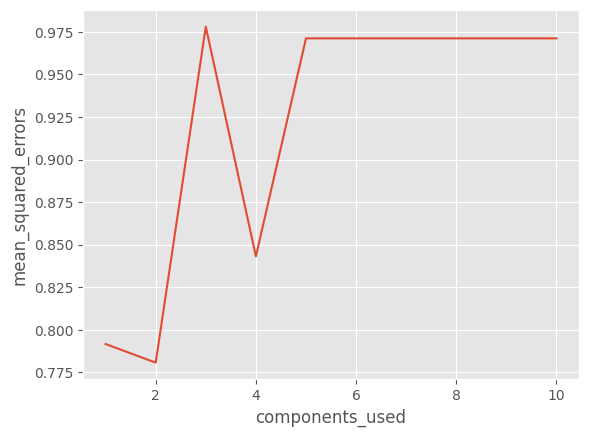

In [59]:
lin_reg = LinearRegression()

components_used = []
mean_squared_errors = []

for i in range(1, 11):
    cv_scores = cross_val_score(estimator=lin_reg,
                                X=X_pca[:, 0:i],
                                y=y,
                                cv=10,
                                scoring="neg_mean_squared_error")

    cv_mean_squared_error = cv_scores.mean() * -1

    components_used.append(i)
    mean_squared_errors.append(cv_mean_squared_error)

mse_by_n_components = \
    pd.DataFrame(data=dict(components_used=components_used,
                           mean_squared_errors=mean_squared_errors))
    
sb.lineplot(data=mse_by_n_components, x='components_used', y='mean_squared_errors')

                            AutoReg Model Results                             
Dep. Variable:               infl_rus   No. Observations:                  132
Model:                   AutoReg-X(2)   Log Likelihood                -137.417
Method:               Conditional MLE   S.D. of innovations              0.696
Date:                Mon, 07 Apr 2025   AIC                            292.835
Time:                        01:28:12   BIC                            318.642
Sample:                             2   HQIC                           303.321
                                  132                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6302      0.088      7.195      0.000       0.459       0.802
infl_rus.L1     0.1248      0.083      1.508      0.132      -0.037       0.287
infl_rus.L2    -0.1580      0.080     -1.981    

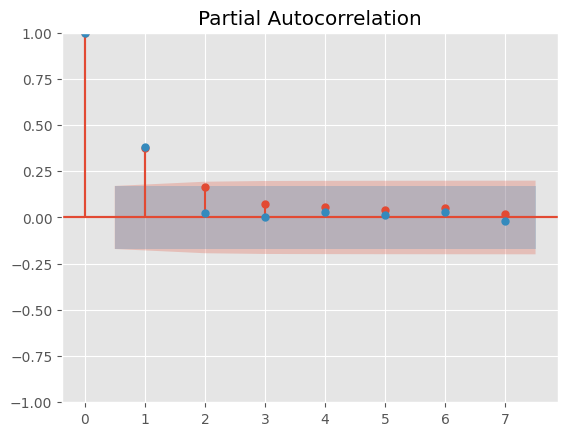

In [61]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['infl_rus'], lags=7, ax=plt.gca())  # lags=20 - количество лагов для отображения
plot_pacf(df['infl_rus'], lags=7, ax=plt.gca(), method='ols')  # method='ols' для PACF

# Построение ARDL модели
model = AutoReg(df['infl_rus'], lags=2, exog=X_pca)
results = model.fit()
result= results.summary()
print(result)

In [75]:
from statsmodels.tsa.ar_model import AutoReg

# Добавляем константу (intercept)
X_sm = sm.add_constant(X_pca)

# OLS-регрессия
model_ols = sm.OLS(y, X_sm)
results_ols = model_ols.fit()

print(results_ols.summary())

# Остатки модели
residuals = results_ols.resid

# Оцениваем AR(p) для остатков
ar_order = 1  # порядок авторегрессии (можно подобрать через AIC)
model_ar = AutoReg(residuals, lags=ar_order)
results_ar = model_ar.fit()

# Прогнозируем AR-ошибки
ar_predictions = results_ar.predict()

# Корректируем исходные данные
y_corrected = y - ar_predictions

# Переоцениваем OLS на скорректированных данных
model_ols_corrected = sm.OLS(y_corrected[1:], X_sm[1:])
results_ols_corrected = model_ols_corrected.fit()
print(results_ols_corrected.summary())

                            OLS Regression Results                            
Dep. Variable:               infl_rus   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.35e-10
Time:                        12:08:43   Log-Likelihood:                -141.32
No. Observations:                 132   AIC:                             294.6
Df Residuals:                     126   BIC:                             311.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6057      0.063      9.632      0.0

In [76]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(X) модель: порядок (1,0,0) = AR(1)
model_arima = ARIMA(y, exog=X_pca, order=(1, 0, 0))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               infl_rus   No. Observations:                  132
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -121.869
Date:                Mon, 07 Apr 2025   AIC                            259.738
Time:                        12:09:29   BIC                            282.801
Sample:                             0   HQIC                           269.110
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3457      1.273      0.272      0.786      -2.149       2.840
x1            -0.5082      0.402     -1.264      0.206      -1.296       0.280
x2             1.0497      0.180      5.831      0.0